# QB vs RB Model

## Import Packages

In [59]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Import and Preprocess Data

In [67]:
input_df = pd.read_csv('Heisman_Winner_QB_vs_RB_Smaller.csv')
#input_df = pd.read_csv('Heisman_Winner_QB_vs_RB_Import.csv')
#print(input_data_cv.head())

#Standardize stats by # of games played
input_df['Pass_Cmp_per_Game_1'] = input_df['Pass_Cmp_1']/input_df['QB_Games_1']
input_df['Pass_Att_per_Game_1'] = input_df['Pass_Att_1']/input_df['QB_Games_1']
input_df['Pass_TD_per_Game_1'] = input_df['Pass_TD_1']/input_df['QB_Games_1']
input_df['Int_per_Game_1'] = input_df['Int_1']/input_df['QB_Games_1']

input_df['Pass_Cmp_per_Game_2'] = input_df['Pass_Cmp_2']/input_df['QB_Games_2']
input_df['Pass_Att_per_Game_2'] = input_df['Pass_Att_2']/input_df['QB_Games_2']
input_df['Pass_TD_per_Game_2'] = input_df['Pass_TD_2']/input_df['QB_Games_2']
input_df['Int_per_Game_2'] = input_df['Int_2']/input_df['QB_Games_2']

input_df['Pass_Cmp_per_Game_3'] = input_df['Pass_Cmp_3']/input_df['QB_Games_3']
input_df['Pass_Att_per_Game_3'] = input_df['Pass_Att_3']/input_df['QB_Games_3']
input_df['Pass_TD_per_Game_3'] = input_df['Pass_TD_3']/input_df['QB_Games_3']
input_df['Int_per_Game_3'] = input_df['Int_3']/input_df['QB_Games_3']

input_df['Rush_Att_per_Game_1'] = input_df['Rush_Att_1']/input_df['RB_Games_1']
input_df['Rush_Yds_per_Game_1'] = input_df['Rush_Yds_1']/input_df['RB_Games_1']
input_df['Rush_TD_per_Game_1'] = input_df['Rush_TD_1']/input_df['RB_Games_1']
input_df['Rec_per_Game_1'] = input_df['Rec_1']/input_df['RB_Games_1']
input_df['Rcv_Yds_per_Game_1'] = input_df['Rcv_Yds_1']/input_df['RB_Games_1']
input_df['Rcv_TD_per_Game_1'] = input_df['Rcv_TD_1']/input_df['RB_Games_1']
input_df['ScrmgPlays_per_Game_1'] = input_df['ScrmgPlays_1']/input_df['RB_Games_1']
input_df['Scrmg_Yds_per_Game_1'] = input_df['Scrmg_Yds_1']/input_df['RB_Games_1']
input_df['Scrmg_TD_per_Game_1'] = input_df['Scrmg_TD_1']/input_df['RB_Games_1']

input_df['Rush_Att_per_Game_2'] = input_df['Rush_Att_2']/input_df['RB_Games_2']
input_df['Rush_Yds_per_Game_2'] = input_df['Rush_Yds_2']/input_df['RB_Games_2']
input_df['Rush_TD_per_Game_2'] = input_df['Rush_TD_2']/input_df['RB_Games_2']
input_df['Rec_per_Game_2'] = input_df['Rec_2']/input_df['RB_Games_2']
input_df['Rcv_Yds_per_Game_2'] = input_df['Rcv_Yds_2']/input_df['RB_Games_2']
input_df['Rcv_TD_per_Game_2'] = input_df['Rcv_TD_2']/input_df['RB_Games_2']
input_df['ScrmgPlays_per_Game_2'] = input_df['ScrmgPlays_2']/input_df['RB_Games_2']
input_df['Scrmg_Yds_per_Game_2'] = input_df['Scrmg_Yds_2']/input_df['RB_Games_2']
input_df['Scrmg_TD_per_Game_2'] = input_df['Scrmg_TD_2']/input_df['RB_Games_2']

input_df['Rush_Att_per_Game_3'] = input_df['Rush_Att_3']/input_df['RB_Games_3']
input_df['Rush_Yds_per_Game_3'] = input_df['Rush_Yds_3']/input_df['RB_Games_3']
input_df['Rush_TD_per_Game_3'] = input_df['Rush_TD_3']/input_df['RB_Games_3']
input_df['Rec_per_Game_3'] = input_df['Rec_3']/input_df['RB_Games_3']
input_df['Rcv_Yds_per_Game_3'] = input_df['Rcv_Yds_3']/input_df['RB_Games_3']
input_df['Rcv_TD_per_Game_3'] = input_df['Rcv_TD_3']/input_df['RB_Games_3']
input_df['ScrmgPlays_per_Game_3'] = input_df['ScrmgPlays_3']/input_df['RB_Games_3']
input_df['Scrmg_Yds_per_Game_3'] = input_df['Scrmg_Yds_3']/input_df['RB_Games_3']
input_df['Scrmg_TD_per_Game_3'] = input_df['Scrmg_TD_3']/input_df['RB_Games_3']

#
print(input_df.head())

   Year            QB_1 QB_Conf_1  QB_Rank_1  QB_Games_1  Pass_Cmp_1  \
0  2023  Jayden Daniels       SEC          5          12         236   
1  2022      Max Duggan    Big 12         12          15         267   
2  2021   Kenny Pickett       ACC          6          13         334   
3  2020      Mac Jones*       SEC          1          13         311   
4  2019      Joe Burrow       SEC          1          15         402   

   Pass_Att_1  Cmp%_1  Pass_Yds_1  Pass_TD_1  ...  Scrmg_TD_per_Game_2  \
0         327    72.2        3812         40  ...             1.571429   
1         419    63.7        3698         32  ...             1.307692   
2         497    67.2        4319         42  ...             1.384615   
3         402    77.4        4500         41  ...             2.307692   
4         527    76.3        5671         60  ...             1.615385   

   Rush_Att_per_Game_3  Rush_Yds_per_Game_3  Rush_TD_per_Game_3  \
0            21.230769           125.153846            

In [68]:
#Create new column to indicate which of the 6 players won the Heisman
input_df['Winner_Coded'] = '999'
for row in range(input_df.shape[0]):
    if input_df['Winner'][row] == input_df['QB_1'][row]:
        input_df.loc[row, 'Winner_Coded'] = 0
    if input_df['Winner'][row] == input_df['QB_2'][row]:
        input_df.loc[row, 'Winner_Coded'] = 1
    if input_df['Winner'][row] == input_df['QB_3'][row]:
        input_df.loc[row, 'Winner_Coded'] = 2
    if input_df['Winner'][row] == input_df['RB_1'][row]:
        input_df.loc[row, 'Winner_Coded'] = 3
    if input_df['Winner'][row] == input_df['RB_2'][row]:
        input_df.loc[row, 'Winner_Coded'] = 4
    if input_df['Winner'][row] == input_df['RB_3'][row]:
        input_df.loc[row, 'Winner_Coded'] = 5


#print(input_df['Winner_Coded'])


In [69]:
#Format conference fileds 
#print(input_df['QB_Conf_1'].unique())
#print(input_df['RB_Conf_1'].unique())
input_df['QB_Conf_1'] = input_df['QB_Conf_1'].str.strip()
input_df['QB_Conf_2'] = input_df['QB_Conf_2'].str.strip()
input_df['QB_Conf_3'] = input_df['QB_Conf_3'].str.strip()
input_df['RB_Conf_1'] = input_df['RB_Conf_1'].str.strip()
input_df['RB_Conf_2'] = input_df['RB_Conf_2'].str.strip()
input_df['RB_Conf_3'] = input_df['RB_Conf_3'].str.strip()

input_df['RB_Conf_1'] = input_df['RB_Conf_1'].replace({'Pac-10':'Pac-12'})
input_df['RB_Conf_2'] = input_df['RB_Conf_2'].replace({'Pac-10':'Pac-12'})
input_df['RB_Conf_3'] = input_df['RB_Conf_3'].replace({'Pac-10':'Pac-12'})
print(input_df['QB_Conf_1'].unique())
print(input_df['RB_Conf_1'].unique())

#Create dummy vars for  conferences
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_1'],prefix='QB1_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_2'],prefix='QB2_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_3'],prefix='QB3_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_1'],prefix='RB1_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_2'],prefix='RB2_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_3'],prefix='RB3_').astype(int)], axis=1)


['SEC' 'Big 12' 'ACC' 'Big Ten' 'MAC' 'Pac-12' 'WAC' 'Big East']
['Big Ten' 'Big 12' 'ACC' 'SEC' 'Pac-12' 'Big East' 'CUSA' 'WAC']


,Year,QB_1,QB_Conf_1,QB_Rank_1,QB_Games_1,Pass_Cmp_1,Pass_Att_1,Cmp%_1,Pass_Yds_1,Pass_TD_1,...,Winner_Coded,RB3__ACC,RB3__Big 12,RB3__Big East,RB3__Big Ten,RB3__CUSA,RB3__MWC,RB3__Pac-12,RB3__SEC,RB3__WAC
0,2023,Jayden Daniels,SEC,5,12,236,327,72.2,3812,40,...,0,0,0,0,0,0,0,0,1,0
1,2022,Max Duggan,Big 12,12,15,267,419,63.7,3698,32,...,2,0,1,0,0,0,0,0,0,0
2,2021,Kenny Pickett,ACC,6,13,334,497,67.2,4319,42,...,2,0,0,0,1,0,0,0,0,0
3,2020,Mac Jones*,SEC,1,13,311,402,77.4,4500,41,...,1,0,0,0,0,1,0,0,0,0
4,2019,Joe Burrow,SEC,1,15,402,527,76.3,5671,60,...,0,0,0,0,1,0,0,0,0,0
5,2018,Dwayne Haskins*,Big Ten,1,14,373,533,70.0,4831,50,...,1,0,0,0,1,0,0,0,0,0
6,2017,Lamar Jackson*,ACC,15,13,254,430,59.1,3660,27,...,1,0,0,0,0,0,1,0,0,0
7,2016,Lamar Jackson,ACC,16,13,230,409,56.2,3543,30,...,0,0,0,0,0,0,0,1,0,0
8,2015,Baker Mayfield*,Big 12,18,13,269,395,68.1,3700,36,...,4,0,0,0,0,0,0,1,0,0
9,2014,J.T. Barrett*,Big Ten,44,12,203,314,64.6,2834,34,...,2,0,0,0,1,0,0,0,0,0


In [70]:
#Drop non-standardized variables
vars_final = input_df.drop(columns = ['Pass_Cmp_1','Pass_Att_1','Pass_Yds_1', 'Pass_TD_1', 'Int_1', 'Rush_Att_1',
                                      'Rush_Yds_1', 'Rush_TD_1', 'Rec_1','Rcv_Yds_1','Rcv_TD_1','ScrmgPlays_1',
                                      'Scrmg_Yds_1','Scrmg_TD_1',
                                      'Pass_Cmp_2','Pass_Att_2','Pass_Yds_2', 'Pass_TD_2', 'Int_2', 'Rush_Att_2',
                                      'Rush_Yds_2', 'Rush_TD_2', 'Rec_2','Rcv_Yds_2','Rcv_TD_2','ScrmgPlays_2',
                                      'Scrmg_Yds_2','Scrmg_TD_2',
                                      'Pass_Cmp_3','Pass_Att_3','Pass_Yds_3', 'Pass_TD_3', 'Int_3', 'Rush_Att_3',
                                      'Rush_Yds_3', 'Rush_TD_3', 'Rec_3','Rcv_Yds_3','Rcv_TD_3','ScrmgPlays_3',
                                      'Scrmg_Yds_3','Scrmg_TD_3',
                                      'Winner', 'QB_Conf_1', 'QB_Conf_2', 'QB_Conf_3', 'RB_Conf_1', 'RB_Conf_2', 'RB_Conf_3'])

#Drop variables we won't be using to predict
vars_final.drop(columns = ['QB_1', 'QB_2', 'QB_3', 'RB_1', 'RB_2', 'RB_3'], inplace=True)
vars_final.drop(columns = ['QB_Rank_1', 'QB_Rank_2', 'QB_Rank_3', 'RB_Rank_1', 'RB_Rank_2', 'RB_Rank_3',
                           'QB_Games_1', 'QB_Games_2', 'QB_Games_3', 'RB_Games_1', 'RB_Games_2', 'RB_Games_3'], inplace=True)

In [71]:
print(vars_final.columns)

Index(['Year', 'Cmp%_1', 'Pass_TD%_1', 'Int%_1', 'Y_per_Atmpt_1',
       'Adj_Y_per_A_1', 'Y_per_C_1', 'Y_per_G_1', 'Pass_Effncy_Rate_1',
       'Cmp%_2', 'Pass_TD%_2', 'Int%_2', 'Y_per_Atmpt_2', 'Adj_Y_per_A_2',
       'Y_per_C_2', 'Y_per_G_2', 'Pass_Effncy_Rate_2', 'Cmp%_3', 'Pass_TD%_3',
       'Int%_3', 'Y_per_Atmpt_3', 'Adj_Y_per_A_3', 'Y_per_C_3', 'Y_per_G_3',
       'Pass_Effncy_Rate_3', 'Rush_Avg_1', 'Rcv_Avg_1', 'Scrmg_Avg_1',
       'Rush_Avg_2', 'Rcv_Avg_2', 'Scrmg_Avg_2', 'Rush_Avg_3', 'Rcv_Avg_3',
       'Scrmg_Avg_3', 'Pass_Cmp_per_Game_1', 'Pass_Att_per_Game_1',
       'Pass_TD_per_Game_1', 'Int_per_Game_1', 'Pass_Cmp_per_Game_2',
       'Pass_Att_per_Game_2', 'Pass_TD_per_Game_2', 'Int_per_Game_2',
       'Pass_Cmp_per_Game_3', 'Pass_Att_per_Game_3', 'Pass_TD_per_Game_3',
       'Int_per_Game_3', 'Rush_Att_per_Game_1', 'Rush_Yds_per_Game_1',
       'Rush_TD_per_Game_1', 'Rec_per_Game_1', 'Rcv_Yds_per_Game_1',
       'Rcv_TD_per_Game_1', 'ScrmgPlays_per_Game_1', 'Scrmg_Y

In [234]:
#Split into train and test
train_set = vars_final[vars_final['Year']% 5 != 0]
test_set = vars_final[vars_final['Year']% 5 == 0]

#Separate some values in train for validation
train_shuffled = train_set.sample(frac=1).reset_index(drop=True)
train_set = train_shuffled[len(train_shuffled)//5:]
val_set = train_shuffled[:len(train_shuffled)//5]

In [72]:
#Create X and y tensors
# X_train = train_set.drop(columns = ['Year','Winner_Coded'])
# y_train = train_set['Winner_Coded']

# X_val = val_set.drop(columns = ['Year','Winner_Coded'])
# y_val = val_set['Winner_Coded']

# X_test = test_set.drop(columns = ['Year','Winner_Coded'])
# y_test = test_set['Winner_Coded']

X = vars_final.drop(columns = ['Year','Winner_Coded'])
y = vars_final['Winner_Coded']

In [236]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(692, 84)
(692,)
(172, 84)
(172,)
(216, 84)
(216,)


In [237]:
#Standardize x variables
train_mean = X_train.mean(axis=0)
X_train -= train_mean
X_val -= train_mean
X_test -= train_mean
train_std = X_train.std(axis=0)
X_train /= train_std
X_val /= train_std
X_test /= train_std

In [8]:
train_mean = X.mean(axis=0)
X -= train_mean
train_std = X.std(axis=0)
X /= train_std

In [73]:
print(X)

    Cmp%_1  Pass_TD%_1  Int%_1  Y_per_Atmpt_1  Adj_Y_per_A_1  Y_per_C_1  \
0     72.2        12.2     1.2           11.7          13.55       16.2   
1     63.7         7.6     1.9            8.8           9.49       13.9   
2     67.2         8.5     1.4            8.7           9.75       12.9   
3     77.4        10.2     1.0           11.2          12.79       14.5   
4     76.3        11.4     1.1           10.8          12.53       14.1   
5     70.0         9.4     1.5            9.1          10.26       13.0   
6     59.1         6.3     2.3            8.5           8.72       14.4   
7     56.2         7.3     2.2            8.7           9.14       15.4   
8     68.1         9.1     1.8            9.4          10.39       13.8   
9     64.6        10.8     3.2            9.0           9.76       14.0   
10    62.6         5.9     2.0            7.2           7.46       11.4   
11    64.8         5.3     3.0            8.7           8.41       13.4   
12    69.1         8.7   

In [75]:

def change_one_hot_label(x, n_classes = 10):
    one_hot_array = np.zeros([x.size, n_classes])
    for idx, entry in enumerate(x):
        one_hot_array[idx, entry] = 1
    return one_hot_array

In [74]:
y_train_one_hot = change_one_hot_label(y_train, n_classes=6)
y_val_one_hot = change_one_hot_label(y_val, n_classes=6)
y_test_one_hot = change_one_hot_label(y_test, n_classes=6)
#print(y_test_one_hot)

NameError: name 'y_train' is not defined

In [76]:
y_one_hot = pd.DataFrame(change_one_hot_label(y, n_classes=6))

In [256]:
#x = np.array([[1,2,3,4,5], [1, 7, 2, 8, 5]])
#normal_layer = layers.Normalization(axis=-1)
#normal_layer.adapt(x)
#y = normal_layer(x)

#Create model
def build_network(X):
    #normal_layer = layers.Normalization(axis=-1)
    #normal_layer.adapt(np.array(X.values))
    #model.add(normal_layer)
    model = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(3, activation = 'relu'),
        layers.Dense(6, activation = 'softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                           optimizer = 'rmsprop',
                           metrics = ['accuracy'])

    return model


In [257]:
my_first_model = build_network(X_test)

In [242]:
callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss', 
        patience=3
    ),
    tf.keras.callbacks.TensorBoard()
    ]

history = my_first_model.fit(X_train, y_train_one_hot, epochs = 50, batch_size = 16, callbacks = callbacks,
                   validation_data = (X_val, y_val_one_hot))

Epoch 1/50
44/44 [==============================] - 1s 18ms/step - loss: 1.7867 - accuracy: 0.2601 - val_loss: 1.7630 - val_accuracy: 0.3256
Epoch 2/50
44/44 [==============================] - 1s 15ms/step - loss: 1.7566 - accuracy: 0.2702 - val_loss: 1.7415 - val_accuracy: 0.2500
Epoch 3/50
44/44 [==============================] - 1s 13ms/step - loss: 1.7377 - accuracy: 0.2847 - val_loss: 1.7211 - val_accuracy: 0.2500
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 1.7197 - accuracy: 0.2847 - val_loss: 1.7027 - val_accuracy: 0.2500
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 1.7044 - accuracy: 0.2847 - val_loss: 1.6861 - val_accuracy: 0.2500
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 1.6901 - accuracy: 0.2789 - val_loss: 1.6701 - val_accuracy: 0.2500
Epoch 7/50
44/44 [==============================] - 0s 11ms/step - loss: 1.6766 - accuracy: 0.2847 - val_loss: 1.6554 - val_accuracy: 0.2500
Epoch 8/50
44

Record of previous trials:

One 10-node layer: train loss 1.5623, train accuracy 0.2818, val loss 1.5020, val accuracy 0.2616

One 30-node layer: train loss 1.5871, train accuracy 0.2818, val loss 1.5448, val accuracy 0.2616

Two 30-node layers: train loss 1.5630, train accuracy 0.2760, val loss 1.5003, val accuracy 0.2616

Standardize data outside of model: train loss 1.5448, train accuracy 0.2673, val loss 1.5730, val accuracy 0.2733

In [243]:
def plot_loss(history):
    plt.clf()
    history_dict = history.history
    loss_values = history_dict['loss']
    print(type(loss_values))
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values)+ 1)
    plt.plot(epochs, loss_values, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'b--', label = 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

<class 'list'>


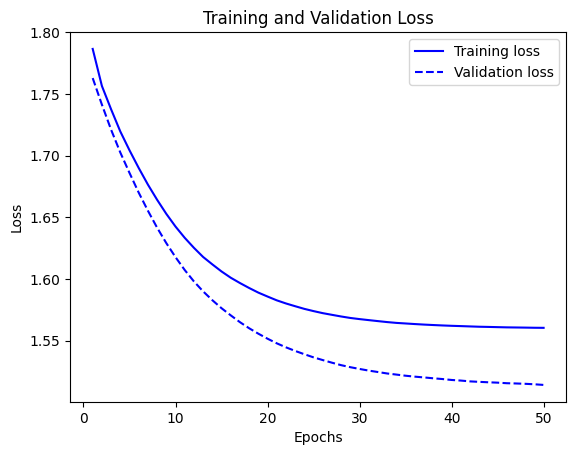

In [244]:
plot_loss(history)

In [245]:
def plot_accuracy(history):
    plt.clf()
    history_dict = history.history
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values)+ 1)
    plt.plot(epochs, acc_values, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc_values, 'b--', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

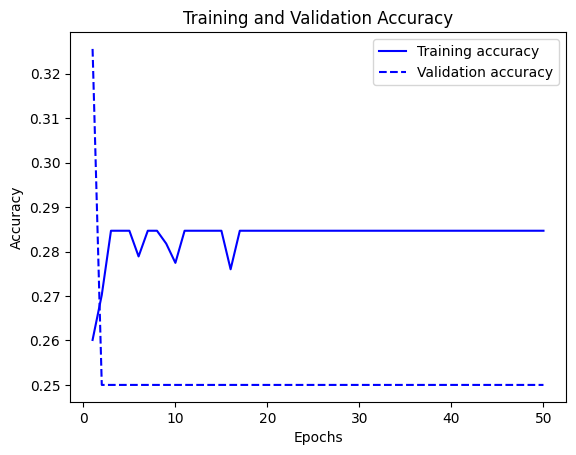

In [246]:
plot_accuracy(history)

In [146]:
results = my_first_model.evaluate(X_test, y_test_one_hot)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

7/7 [==============================] - 0s 15ms/step - loss: 2.0767 - accuracy: 0.1667
Test Loss: 2.076655864715576
Test Accuracy: 0.1666666716337204


In [147]:
print(my_first_model.predict(X_test))
#print(X_test[0:1])
#print(X_test[-1:])

7/7 [==============================] - 0s 9ms/step
[[0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 ...
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]]


In [127]:

#Create model
def build_network(X):
    #normal_layer = layers.Normalization(axis=-1)
    #normal_layer.adapt(np.array(X.values))
    #model.add(normal_layer)
    model = tf.keras.Sequential([
        layers.Dense(3, activation = 'relu'),
        layers.Dense(3, activation = 'relu'),
        layers.Dense(6, activation = 'softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                           optimizer = 'rmsprop',
                           metrics = ['accuracy'])

    return model

In [128]:
def leave_one_out_train(X, y):
    callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'loss', 
        patience=3
    ),
    tf.keras.callbacks.TensorBoard()
    ]

    losses = []
    accuracies = []
    for i in range(len(y)):
        #print(y.shape)
        y_train = y.copy()
        y_test = pd.DataFrame(y.iloc[i,:]).transpose()
        y_train.drop([i], inplace=True)
        #print(y_train.shape)
        #print(y_test.shape)
        #print(X.shape)
        X_train = X.copy()
        X_test = pd.DataFrame(X.iloc[i,:]).transpose()
        X_train.drop([i], inplace=True)
        #print(X_train.shape)
        #print(X_test.shape)

        my_model = build_network(X)
        my_model.fit(X_train, y_train, epochs = 10, batch_size = 8, callbacks = callbacks)
        error = my_model.evaluate(X_test, y_test)
        losses.append(error[0])
        accuracies.append(error[1])
        print(f'Finished round {i+1}')
    return losses, accuracies


In [129]:
loss_list, accuracy_list = leave_one_out_train(X, y_one_hot)

Epoch 1/10
4/4 [==============================] - 1s 14ms/step - loss: 122.1290 - accuracy: 0.2069
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 1.7882 - accuracy: 0.4138
Epoch 3/10
4/4 [==============================] - 0s 20ms/step - loss: 1.7861 - accuracy: 0.4138
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 1.7842 - accuracy: 0.4138
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 1.7827 - accuracy: 0.4138
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 1.7811 - accuracy: 0.4138
Epoch 7/10
4/4 [==============================] - 0s 15ms/step - loss: 1.7796 - accuracy: 0.4138
Epoch 8/10
4/4 [==============================] - 0s 14ms/step - loss: 1.7781 - accuracy: 0.4138
Epoch 9/10
4/4 [==============================] - 0s 17ms/step - loss: 1.7767 - accuracy: 0.4138
Epoch 10/10
1/1 [==============================] - 0s 140ms/step - loss: 1.7958 - accuracy: 0.0000e+00
Finished round 1
Epoch

In [130]:
print(f'Average Loss: {np.average(loss_list)}')
print(f'Average Accuracy: {np.average(accuracy_list)}')

Average Loss: 1.780821478366852
Average Accuracy: 0.4


Results with Different Models

2 30-layers: loss 1.646, accuracy 0.4

Add early stopping: loss 1.599, accuracy 0.4

20 epochs: loss 1.608, accuracy 0.4

Added input layer: loss = 1.611, accuracy 0.4

1 5-Layer: loss 1.612, accuracy 0.4

3 epochs: loss 1.571, accuracy 0.4

In [131]:
callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'loss', 
        patience=3
    ),
    tf.keras.callbacks.TensorBoard()
    ]
final_model = build_network(X)
final_model.fit(X, y_one_hot, epochs = 10, batch_size = 8, callbacks = callbacks)

Epoch 1/10
4/4 [==============================] - 0s 8ms/step - loss: 19.7349 - accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 1.7877 - accuracy: 0.4000
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 1.7857 - accuracy: 0.4000
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: 1.7841 - accuracy: 0.4000
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 1.7821 - accuracy: 0.4000
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 1.7807 - accuracy: 0.4000
Epoch 7/10
4/4 [==============================] - 0s 47ms/step - loss: 1.7789 - accuracy: 0.4000
Epoch 8/10
4/4 [==============================] - 0s 11ms/step - loss: 1.7775 - accuracy: 0.4000
Epoch 9/10
4/4 [==============================] - 0s 11ms/step - loss: 1.7761 - accuracy: 0.4000
Epoch 10/10
4/4 [==============================] - 0s 9ms/step - loss: 1.7743 - accuracy: 0.4000


In [132]:
final_model.predict(X)

1/1 [==============================] - 0s 56ms/step


array([[0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0.16937928, 0.17449932, 0.15988432, 0.16449717,
        0.16332327],
       [0.16841668, 0